## Run LAS

In [5]:
#Build Molecule
import numpy as np
from pyscf import gto, scf, lib, mcscf
import math
import time
import os
from tools import sign_control, util
from systems.npjunc import NPJunc

geom = NPJunc(dist=2.5,fn="logs/npjunc.log")
las = geom.make_las_state_average()

#Build LAS states
print("Initiating LAS Model Space...")
start = time.perf_counter()
las.lasci_(lroots=geom.lroots)
# las.ci = sign_control.fix_sign(las)
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds")
las.dump_spaces()

# Run LASSI
print("Running LASSI...")
start = time.perf_counter()
from mrh.my_pyscf import lassi
lsi = lassi.LASSI(las)
energies_lassi, civecs_lassi = lsi.kernel(lroots=geom.lroots)
# civecs_lassi = lsi.get_sivec_vacuum_shuffle(state=0)
stop = time.perf_counter()
print("Done. Time elapsed:",stop-start,"seconds") #takes about 3 minutes on 16 cores

overwrite output file: logs/npjunc.log
Initiating LAS Model Space...
Done. Time elapsed: 123.08173452399933 seconds
Running LASSI...


WARN: Dumping only 100 of 113 spaces
WARN: To see more, explicitly pass nroots to dump_spaces or increase verbosity


Done. Time elapsed: 22.504008403004264 seconds


In [3]:
###Save Results w/ Pickle
import pickle

def dump_pkl(obj,fn):
    with open(fn,"wb+") as file:
        pickle.dump(obj,file)

results = {
    "energies_lassi":energies_lassi,
    "civecs_lassi":civecs_lassi,
    "n_frag":geom.n_frag,
    "p_frag":geom.p_frag,
    "ex_frag":geom.ex_frag,
    "las_charges":geom.las_charges,
    "nfrags":geom.nfrags,
}
dump_pkl(results,"logs/npjunc.pkl")

## Plotting

/home/king1305/LAS_ET/periodiclas/tools/util.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]*8);


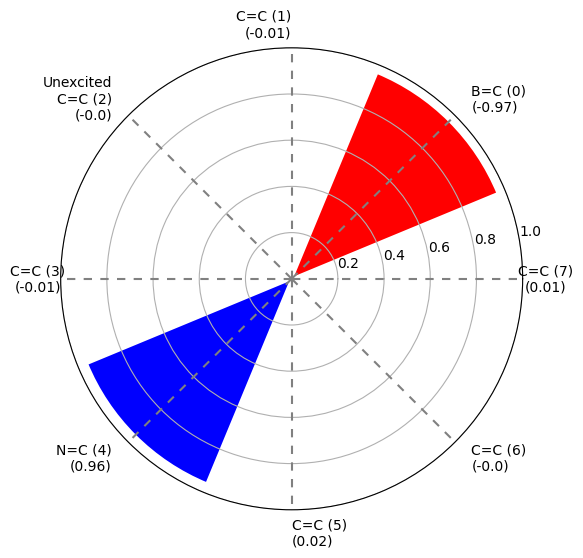

In [8]:
import pickle
import numpy as np
from tools.util import load_pkl

def calc_charges(results,state="gs"):
    assert(state in ["gs","exs"])
    civecs_lassi = results["civecs_lassi"]
    energies_lassi = results["energies_lassi"]
    class Obj:
        def __init__(self,results):
            self.n_frag = results["n_frag"]
            self.p_frag = results["p_frag"]
            self.ex_frag = results["ex_frag"]
            self.las_charges = results["las_charges"]
            self.nfrags = results["nfrags"]
    geom = Obj(results)
    
    from dsk.las.bandh import make_h
    H = make_h(civecs_lassi,energies_lassi,prnt=False)
    if state == "gs":
        states = [i for i in list(range(H.shape[0])) if i != 1] #exclude es
        H = H[np.ix_(states,states)]
    energies,civecs = np.linalg.eigh(H)

    p = civecs[:,0]**2
    charges = np.zeros(geom.nfrags)
    charges[geom.n_frag] = 1
    charges[geom.p_frag] = -1
    if state == "gs":
        p = civecs[:,0]**2
        charges = geom.las_charges + charges
    elif state == "exs":
        p = civecs[:,1]**2
        charges = np.vstack([geom.las_charges[0],geom.las_charges]) + charges
    charges = (charges * p[:,None]).sum(axis=0)
    labels = []
    for i in range(geom.nfrags):
        if i == geom.n_frag:
            labels += [f"{i} N=C ({i})"]
        elif i == geom.p_frag:
            labels += [f"{i} B=C ({i})"]
        elif i == geom.ex_frag:
            if state == "gs":
                labels += [f"{i} Unexcited\nC=C ({i})"]
            elif state == "exs":
                labels += [f"{i} Excited\n(C=C)* ({i})"]
        else:
            labels += [f"{i} C=C ({i})"]
    return charges,labels

results = load_pkl("logs/npjunc.pkl")
charges,labels = calc_charges(results,state="gs")
util.plot_charges(charges,labels)

/home/king1305/LAS_ET/example_scripts/tools/util.py:78: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""]*8);


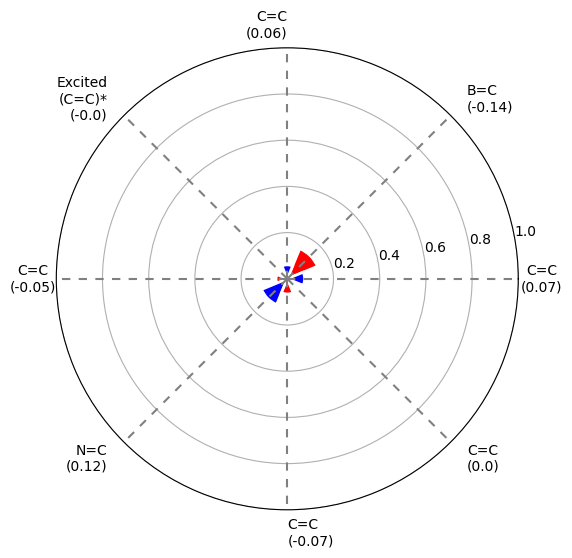

In [8]:
results = load_pkl("logs/npjunc.pkl")
charges,labels = calc_charges(results,state="exs")
util.plot_charges(charges,labels)

[-610.31 -609.8  -610.   -610.   -610.02 -610.02 -610.11 -610.11 -610.27
 -610.27 -610.06 -610.06 -609.98 -609.98 -609.96 -609.96 -609.62 -609.62
 -609.9  -609.9  -609.93 -609.93 -610.07 -610.07 -609.84 -609.84 -609.75
 -609.75 -609.67 -609.67 -609.43 -609.43 -609.72 -609.72 -609.92 -609.92
 -610.   -610.   -609.75 -609.75 -609.64 -609.64 -609.54 -609.54 -609.29
 -609.29 -609.52 -609.52 -609.71 -609.71 -609.98 -609.98 -609.67 -609.67
 -609.54 -609.54 -609.42 -609.42 -609.15 -609.15 -609.34 -609.34 -609.47
 -609.47 -609.68 -609.68 -609.62 -609.62 -609.43 -609.43 -609.29 -609.29
 -609.34 -609.34 -609.53 -609.53 -609.63 -609.63 -609.78 -609.78 -610.03
 -610.03 -609.72 -609.72 -609.51 -609.51 -609.47 -609.47 -609.63 -609.63
 -609.72 -609.72 -609.84 -609.84 -610.04 -610.04 -609.9  -609.9  -609.7
 -609.7  -609.68 -609.68 -609.78 -609.78 -609.84 -609.84 -609.95 -609.95
 -610.13 -610.13 -609.93 -609.93 -609.92 -609.92]


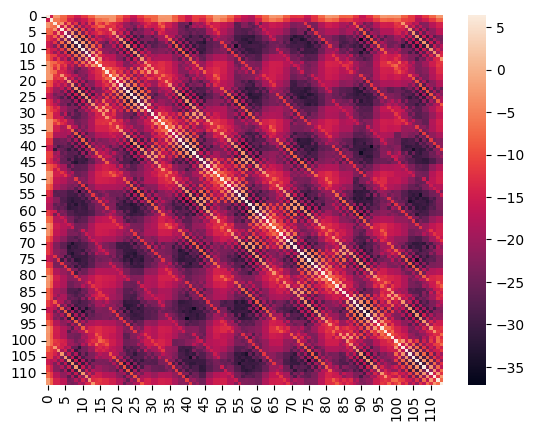

In [6]:
import pickle
import matplotlib.pyplot as plt

def load_pkl(fn):
    with open(fn,"rb") as file:
        return pickle.load(file)
        
from tools.bandh import make_h
import numpy as np
results = load_pkl("logs/npjunc.pkl")
H = make_h(results["civecs_lassi"],results["energies_lassi"],plot=False)
for i in range(H.shape[0]):
    H[i][np.where(H[i] != 0)] = np.log(np.abs(H[i][np.where(H[i] != 0)]))
    H[i][np.where(H[i] == 0)] = -20
import seaborn as sns
sns.heatmap(H)
plt.savefig("../figures/npjunc_hamiltonian_log.png",dpi=500)

[-610.31 -609.8  -610.   -610.   -610.02 -610.02 -610.11 -610.11 -610.27
 -610.27 -610.06 -610.06 -609.98 -609.98 -609.96 -609.96 -609.62 -609.62
 -609.9  -609.9  -609.93 -609.93 -610.07 -610.07 -609.84 -609.84 -609.75
 -609.75 -609.67 -609.67 -609.43 -609.43 -609.72 -609.72 -609.92 -609.92
 -610.   -610.   -609.75 -609.75 -609.64 -609.64 -609.54 -609.54 -609.29
 -609.29 -609.52 -609.52 -609.71 -609.71 -609.98 -609.98 -609.67 -609.67
 -609.54 -609.54 -609.42 -609.42 -609.15 -609.15 -609.34 -609.34 -609.47
 -609.47 -609.68 -609.68 -609.62 -609.62 -609.43 -609.43 -609.29 -609.29
 -609.34 -609.34 -609.53 -609.53 -609.63 -609.63 -609.78 -609.78 -610.03
 -610.03 -609.72 -609.72 -609.51 -609.51 -609.47 -609.47 -609.63 -609.63
 -609.72 -609.72 -609.84 -609.84 -610.04 -610.04 -609.9  -609.9  -609.7
 -609.7  -609.68 -609.68 -609.78 -609.78 -609.84 -609.84 -609.95 -609.95
 -610.13 -610.13 -609.93 -609.93 -609.92 -609.92]


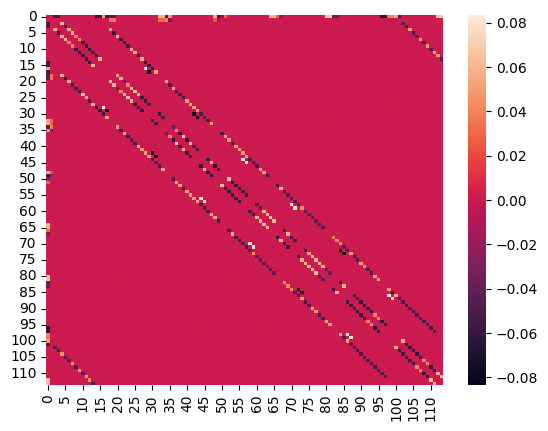

In [7]:
import pickle

def load_pkl(fn):
    with open(fn,"rb") as file:
        return pickle.load(file)
        
from tools.bandh import make_h
import numpy as np
results = load_pkl("logs/npjunc.pkl")
H = make_h(results["civecs_lassi"],results["energies_lassi"],plot=False)
H = H - np.diag(np.diag(H))
import seaborn as sns
sns.heatmap(H)
plt.savefig("../figures/npjunc_hamiltonian_nodiag.png",dpi=500)